# Preparing the data for the model

+ **Read** the **wave** and **image** datasets.
+ **Categorise** every wave of the dataset into **2 classes** regards the Hs wave-parameter (**L:Low and H:High**).
+ **Normalize** the **image values** and save it in a numpy array (X.npy).
+ **Encode** the label categories with **OneHotEncoder** and save it in a numpy array (y.npy).

In [1]:
# Load the necessary modules
import re
import numpy as np
import pandas as pd
import os
import imageio
from skimage import transform,io
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Set the paths
path_waves = r'D:/Capstone Project/Wave data/' # Path where the waves dataset is saved
path_images = r'D:/Capstone Project/Images_web_scraping/edited_images/' # Path where edited images dataset is saved
path_outputs = r'D:/Capstone Project/Data ready to import into DL model/binary approach/' # Path to save the outputs of this notebook

## Waves data

In [3]:
# Load wave data
waves = pd.read_csv(path_waves+'waves_simar_cdf_cal.csv', header=0, delimiter=';')

In [4]:
waves.head()

,Year,Month,Day,Hour,Minute,Second,Hs,Tp,Dir
0,2010,1,1,0,0,0,2.104998,8.86,210
1,2010,1,1,1,0,0,2.095924,8.71,214
2,2010,1,1,2,0,0,2.095924,8.57,217
3,2010,1,1,3,0,0,2.095924,8.43,221
4,2010,1,1,4,0,0,2.095924,8.61,225


In [5]:
print("Time extent of the whole wave dataset (hourly time resolution):\n")
print("From-> Year:{0}, Month:{1}, Day:{2}, Hour:{3}".format(waves.loc[0,"Year"],waves.loc[0,"Month"],waves.loc[0,"Day"],waves.loc[0,"Hour"]))
print("To-> Year:{0}, Month:{1}, Day:{2}, Hour:{3}".format(waves.loc[waves.index[-1],"Year"],waves.loc[waves.index[-1],"Month"],waves.loc[waves.index[-1],"Day"],waves.loc[waves.index[-1],"Hour"]))

Time extent of the whole wave dataset (hourly time resolution):

From-> Year:2010, Month:1, Day:1, Hour:0
To-> Year:2022, Month:5, Day:31, Hour:23


In [6]:
# Create the Hs categories
hs_category = np.zeros(len(waves)).tolist()

for i in range(len(waves)):
    if waves["Hs"][i] <=1:
        hs_category[i] = "L" #Low Hs [0-1 m]
    elif waves["Hs"][i] >1:
        hs_category[i] = "H" #High Hs [> 1 m]

# Add the Hs categories into the df
waves["Hs_category"] = hs_category

# Count of every class
print("\nCounts of whole waves dataset:")
print(waves["Hs_category"].value_counts())


Counts of whole waves dataset:
L    95090
H    13432
Name: Hs_category, dtype: int64


In [7]:
waves.head()

,Year,Month,Day,Hour,Minute,Second,Hs,Tp,Dir,Hs_category
0,2010,1,1,0,0,0,2.104998,8.86,210,H
1,2010,1,1,1,0,0,2.095924,8.71,214,H
2,2010,1,1,2,0,0,2.095924,8.57,217,H
3,2010,1,1,3,0,0,2.095924,8.43,221,H
4,2010,1,1,4,0,0,2.095924,8.61,225,H


## Images data

In [8]:
# Label each image
list_images = os.listdir(path_images) # list of the names of all the image files
paths_each_image = np.zeros(len(list_images)).tolist() # list of individual paths of the images to fill
images_categories = np.zeros(len(list_images)).tolist() # list of the individual Hs categories to fill

for i in range(len(list_images)):
    # Extract the individual path of the i image file
    paths_each_image[i] = str(path_images)+str(list_images[i])
    
    # Extract year, month, day and hour of i image file using regex
    str_date_filename = re.search(r'\d{4}\d{2}\d{2}\d{2}', str(list_images[i]))
    str_date_filename = str_date_filename.group()
    year_image = int(str_date_filename[0:4])
    month_image = int(str_date_filename[4:6])
    day_image = int(str_date_filename[6:8])
    hour_image = int(str_date_filename[8:10])
    
    # Extract the corresponding Hs-category of i image file
    images_categories[i] = str(waves[(waves["Year"]==year_image) &
          (waves["Month"]==month_image) &
          (waves["Day"]==day_image) &
          (waves["Hour"]==hour_image)]["Hs_category"].tolist()[0])

# Create a df with the individual paths and its Hs categories
df_images_categories = pd.DataFrame(np.transpose(np.array([paths_each_image, images_categories])),
                                    columns=["path_image", "Hs_category"])

In [9]:
df_images_categories.head()

,path_image,Hs_category
0,D:/Capstone Project/Images_web_scraping/edited...,L
1,D:/Capstone Project/Images_web_scraping/edited...,L
2,D:/Capstone Project/Images_web_scraping/edited...,L
3,D:/Capstone Project/Images_web_scraping/edited...,L
4,D:/Capstone Project/Images_web_scraping/edited...,L


In [10]:
# Count of every class and save the df
print("Counts of images waves dataset:")
print(df_images_categories["Hs_category"].value_counts())
df_images_categories.to_csv(path_outputs+'df_images_categories.csv', index=False)


Counts of images waves dataset:
L    10575
H     2949
Name: Hs_category, dtype: int64


(([], []), ([], []))

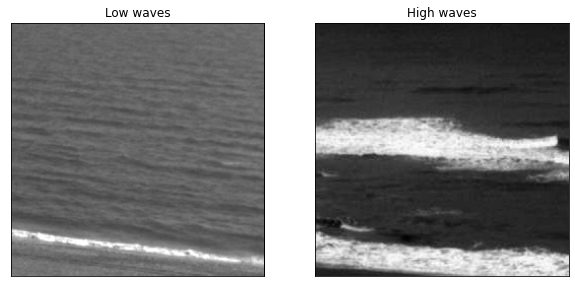

In [4]:
# See an example
import cv2
img_L = cv2.imread(df_images_categories.loc[734, "path_image"],0)
img_H = cv2.imread(df_images_categories.loc[45, "path_image"],0)

plt.gcf().set_size_inches(10,10)
plt.subplot(121),plt.imshow(img_L, cmap='gray'),plt.title('Low waves')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_H, cmap='gray'),plt.title('High waves')
plt.xticks([]), plt.yticks([])

## Prepare the X and y arrays for the model

In [11]:
# Build the arrays
X = [] # np-array of the images
y = [] # np-array of the encoded labels

for ind, item in tqdm(df_images_categories.iterrows(), total=len(df_images_categories)):
    # Normalize values in the 0-1 range
    im = imageio.imread(item[0])/255.
    X.append(im)

X = np.array(X)

hs_encoder = OneHotEncoder(handle_unknown='ignore')
hs_cat_1hot = hs_encoder.fit_transform(df_images_categories[["Hs_category"]]).toarray()

# Save the np arrays
np.save(path_outputs+'X', X)
np.save(path_outputs+'y', hs_cat_1hot)

  0%|          | 0/13524 [00:00<?, ?it/s]

In [12]:
hs_encoder.categories_

[array(['H', 'L'], dtype=object)]